In [1]:
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

In [2]:
print(torch.__version__)

2.3.0+cu121


In [3]:
# SPEECH_URL = "https://keithito.com/LJ-Speech-Dataset/LJ025-0076.wav"
SPEECH_FILE = "../datafiles/Brainhack/audio/audio_0.wav"
if not os.path.exists(SPEECH_FILE):
    # os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

In [4]:
IPython.display.Audio(SPEECH_FILE)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample Rate: {bundle.sample_rate}")
print(f"Labels: {bundle.get_labels()}")
model = bundle.get_model().to(device)
print(model.__class__)

Using device cpu
Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [6]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [7]:
with torch.inference_mode():
    emission, _ = model(waveform)

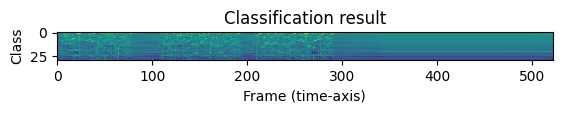

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
29


In [38]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())
print(len(bundle.get_labels()))

In [9]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
        emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
        str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1) # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [10]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
transcript

'THAT|HEN|AS|ONE|FINDS|FELO|DOG|IN|THE|STRING|TO|MOSOLETROV|TOWARD|OF|THE|BOYS|AN|E|COMAGNETIC|ONTS|'

In [11]:
print(emission[0].size())

torch.Size([266, 29])


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from tempfile import TemporaryDirectory
import os
import json
from torchinfo import summary
import pandas as pd

In [14]:
audio_data_dir = '../datafiles/Brainhack/audio/'
nlp_json_data_path = '../datafiles/Brainhack/json/nlp.jsonl'
asr_json_data_path = '../datafiles/Brainhack/json/asr.jsonl'

In [15]:
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Use the function
data = read_jsonl(asr_json_data_path)
print(data)

[{'key': 0, 'audio': 'audio_0.wav', 'transcript': 'Heading is one five zero, target is green commercial aircraft, tool to deploy is electromagnetic pulse.'}, {'key': 1, 'audio': 'audio_1.wav', 'transcript': 'Heading is two six zero, target is black, white, and yellow commercial aircraft, tool to deploy is surface-to-air missiles.'}, {'key': 2, 'audio': 'audio_2.wav', 'transcript': 'Heading is one zero five, target is silver, green, and yellow light aircraft, tool to deploy is anti-air artillery.'}, {'key': 3, 'audio': 'audio_3.wav', 'transcript': 'Heading is two niner zero, target is brown and blue cargo aircraft, tool to deploy is electromagnetic pulse.'}, {'key': 4, 'audio': 'audio_4.wav', 'transcript': 'Heading is zero one five, target is yellow camouflage drone, tool to deploy is EMP.'}, {'key': 5, 'audio': 'audio_5.wav', 'transcript': 'Heading is two seven five, target is purple, orange, and blue cargo aircraft, tool to deploy is interceptor jets.'}, {'key': 6, 'audio': 'audio_6.w

In [16]:
summary(model)

Layer (type:depth-idx)                                  Param #
Wav2Vec2Model                                           --
├─FeatureExtractor: 1-1                                 --
│    └─ModuleList: 2-1                                  --
│    │    └─ConvLayerBlock: 3-1                         6,144
│    │    └─ConvLayerBlock: 3-2                         786,432
│    │    └─ConvLayerBlock: 3-3                         786,432
│    │    └─ConvLayerBlock: 3-4                         786,432
│    │    └─ConvLayerBlock: 3-5                         786,432
│    │    └─ConvLayerBlock: 3-6                         524,288
│    │    └─ConvLayerBlock: 3-7                         524,288
├─Encoder: 1-2                                          --
│    └─FeatureProjection: 2-2                           --
│    │    └─LayerNorm: 3-8                              1,024
│    │    └─Linear: 3-9                                 393,984
│    │    └─Dropout: 3-10                               --
│    └─Tra

In [17]:
def get_files_and_transcript_from_asr_jsonl():
    data = read_jsonl(asr_json_data_path)
    df = pd.DataFrame(data)
    audio_files = []
    transcripts = []
    transcripts_from_asr_file = df['transcript'].to_list()
    for idx, audio_file_path in enumerate(df['audio'].to_list()):
        if Path(audio_data_dir + audio_file_path).exists():
            audio_files.append(audio_data_dir + audio_file_path)
            transcripts.append(transcripts_from_asr_file[idx])
        else:
            print(audio_file_path)
    return  audio_files, transcripts, transcripts_from_asr_file

audio_files, transcriptions, all_transcriptions = get_files_and_transcript_from_asr_jsonl()
print(len(audio_files))
print(len(transcriptions))

3500
3500


In [18]:
def basis_vector(length, i, dtype):
    tensor = torch.zeros(length, dtype=dtype)
    tensor[i] = 1
    return tensor

def text_to_tensor(bundle, text):
    labels = bundle.get_labels()
    text = text.upper()
    indices = []
    labels_len = len(labels)
    for a in text:
        if a == ' ' or a == '.' or a==',':
            indices.append(basis_vector(labels_len, labels.index('|'), torch.float32))
        else:
            indices.append(basis_vector(labels_len, labels.index(a), torch.float32))

    indices_tensor = torch.stack(indices)
    
    return indices_tensor

def load_and_preprocess_audio(bundle, audio_file_path):
    waveform, sample_rate = torchaudio.load(audio_file_path)
    waveform = waveform.to(device)
    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    return waveform

print(transcriptions[0])
print(bundle.get_labels())
transcription_as_tensor = text_to_tensor(bundle, transcriptions[0])
print(transcription_as_tensor.size())
print(decoder(transcription_as_tensor))

Heading is one five zero, target is green commercial aircraft, tool to deploy is electromagnetic pulse.
('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
torch.Size([103, 29])
HEADING|IS|ONE|FIVE|ZERO|TARGET|IS|GREN|COMERCIAL|AIRCRAFT|TOL|TO|DEPLOY|IS|ELECTROMAGNETIC|PULSE|


In [19]:
print(load_and_preprocess_audio(bundle, audio_files[1]).shape)
print(text_to_tensor(bundle, transcriptions[1]).shape)

torch.Size([1, 134165])
torch.Size([123, 29])


In [20]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
# https://pytorch.org/audio/stable/generated/torchaudio.pipelines.Wav2Vec2ASRBundle.html?highlight=torchaudio+pipelines+wav2vec2asrbundle#torchaudio.pipelines.Wav2Vec2ASRBundle

In [21]:
from torch.nn.utils.rnn import pad_sequence
a = torch.ones(25, 300)
b = torch.ones(22, 300)
c = torch.ones(15, 300)
pad_sequence([a, c, b], batch_first=True).size()

torch.Size([3, 25, 300])

In [22]:
print(load_and_preprocess_audio(bundle, audio_files[0]).shape)
print(load_and_preprocess_audio(bundle, audio_files[1]).shape)

torch.Size([1, 85264])
torch.Size([1, 134165])


In [23]:
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

In [24]:
def collate_fn(batch):
    max_length_sequences =  max(x[0].size(1) for x in batch)
    padded = []
    transcript_padded = pad_sequence([x[1] for x in batch], batch_first=True)
    audio_padded = pad_sequence([x[0].permute(1, 0) for x in batch], batch_first=True)
    for idx in range(len(batch)):
        d_ = []
        d_.append(audio_padded[idx].permute(1, 0))
        d_.append(transcript_padded[idx])
        d_ = tuple(d_)
        padded.append(d_)

    return padded

class ASRDataset(Dataset):
    def __init__(self, audio_files, transcriptions):
        self.audio_files = audio_files
        self.transcriptions = [text_to_tensor(bundle, transcription) for transcription in transcriptions]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio = load_and_preprocess_audio(bundle, self.audio_files[idx])
        transcription = self.transcriptions[idx]
        return audio, transcription

dataset = ASRDataset(audio_files, transcriptions)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [32]:
s_batch = next(iter(data_loader))
waveform = s_batch[0][0]


with torch.no_grad():
    emission, _ = model(waveform)

print(decoder(emission[0]))

HEADING|IS|TOSITO|FIVE|DOG|GET|HIS|SILVER|AND|BROOM|ISIDE|THE|WORD|ORD|EPLOY|IS|MACHINE|GUN|


In [33]:
print(s_batch[0][0].size())
print(s_batch[0][1].size())

torch.Size([1, 167184])
torch.Size([122, 29])


In [ ]:
def train(model, num_epochs, 
          dataloader,loss_fn : nn.Module,
          optimizer,device
          ):
    
    